In [1]:
%cd /home/yokoyama/research
from types import SimpleNamespace
import sys
import os
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

sys.path.append(".")
from modules.utils.video import Capture, Writer
from modules.pose import PoseDataHandler

/raid6/home/yokoyama/research


In [2]:
from submodules.i3d.pytorch_i3d import InceptionI3d
from torchvision.ops import roi_align

In [3]:
video_num = 1
cap = Capture(f"/raid6/home/yokoyama/datasets/dataset01/train/{video_num:02d}.mp4")
pose_data = PoseDataHandler.load(f"data/dataset01/train/{video_num:02d}", ["bbox"])

In [4]:
def load_frames_flows(cap, resize_ratio):
    frames = []
    w, h = cap.size
    flows = [np.zeros((int(h * resize_ratio), int(w * resize_ratio), 2))]
    pre_gray = None
    for frame_num in tqdm(range(cap.frame_count)):
        frame_num += 1

        frame = cap.read()[1]
        frame = cv2.resize(frame, None, fx=resize_ratio, fy=resize_ratio)
        frames.append(frame / 255.)
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        if frame_num == 1:
            pre_gray = gray
            continue

        flow = cv2.calcOpticalFlowFarneback(pre_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        flows.append(flow)

        pre_gray = gray

    frames = np.array(frames)
    flows = np.array(flows)

    return frames, flows

resize_ratio = 0.25
frames_raw, flows_raw = load_frames_flows(cap, resize_ratio)

100%|██████████| 5400/5400 [04:00<00:00, 22.49it/s]


In [5]:
def create_batch(frames, flows, start_frame_nums, length):
    batches_frame = []
    batches_flow = []
    for start in tqdm(start_frame_nums):
        batches_frame.append(frames[start:start + length])
        batches_flow.append(flows[start:start + length])
    return np.array(batches_frame, dtype=np.float32), np.array(batches_flow, dtype=np.float32)


batch_num = 64
frame_length = 30
start_frame_num = 1360
# start_frame_nums = sorted(np.random.choice(cap.frame_count, batch_num, replace=True) + start_frame_num)
start_frame_nums = sorted(np.random.choice(64, batch_num, replace=False) + start_frame_num)
frames, flows = create_batch(frames_raw, flows_raw, start_frame_nums, frame_length)
print(start_frame_nums)

100%|██████████| 64/64 [00:00<00:00, 235676.43it/s]


[1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423]


In [6]:
frames = torch.Tensor(frames)
frames = torch.permute(frames, (0, 4, 1, 2, 3))

flows = torch.Tensor(flows)
flows = torch.permute(flows, (0, 4, 1, 2, 3))

frames.shape

torch.Size([64, 3, 30, 235, 320])

In [7]:
model_path_frame = "submodules/i3d/models/rgb_imagenet.pt"
# model_path_frame = "submodules/i3d/models/rgb_charades.pt"
i3d_frame = InceptionI3d(in_channels=3)
# i3d.cuda(1)
# i3d_frame.replace_logits(157)
# i3d_frame.load_state_dict(torch.load(model_path_frame))

model_path_flow = "submodules/i3d/models/flow_imagenet.pt"
# model_path_flow = "submodules/i3d/models/flow_charades.pt"
i3d_flow = InceptionI3d(in_channels=2)
# i3d.cuda(1)
# i3d_flow.replace_logits(157)
# i3d_flow.load_state_dict(torch.load(model_path_flow))

# i3d = InceptionI3d(in_channels=in_channels, final_endpoint="Mixed_3b")
# i3d.build()
# i3d.cuda(1)
print("done")

done


In [8]:
# feature = i3d.extract_features(tensor)
x = frames
for end_point in i3d_frame.VALID_ENDPOINTS:
    if end_point in i3d_frame.end_points:
        x = i3d_frame._modules[end_point](x)
    if end_point == "Mixed_3b":
        # x = i3d_frame.avg_pool(x)
        break
feature_frame = x.cpu()
feature_frame.shape

torch.Size([64, 256, 15, 30, 40])

In [9]:
# feature = i3d.extract_features(tensor)
x = flows
for end_point in i3d_flow.VALID_ENDPOINTS:
    if end_point in i3d_flow.end_points:
        x = i3d_flow._modules[end_point](x)
    if end_point == "Mixed_3b":
        # x = i3d_flow.avg_pool(x)
        break
feature_flow = x.cpu()
feature_flow.shape

torch.Size([64, 256, 15, 30, 40])

In [10]:
feature = feature_frame + feature_flow
feature.shape

torch.Size([64, 256, 15, 30, 40])

In [11]:
h, w = frames.shape[3:5]
fy, fx = feature.shape[3:5]
fx / w

0.125

In [12]:
bboxs_all = []
for start_frame_num in start_frame_nums:
    pose_data_frame = [
        data for data in pose_data
        if data["frame"] == start_frame_num + frame_length // 2 + 1
    ]

    bboxs = [np.array(data["bbox"]).reshape(2, 2) * resize_ratio for data in pose_data_frame]

    bboxs = torch.Tensor(np.array(bboxs))
    # bboxs /= torch.Tensor((w, h))
    # bboxs *= torch.Tensor((fx, fy))

    bboxs_all.append(bboxs.reshape(-1, 4))

output_size = 3
feature_aligned = roi_align(feature, bboxs_all, output_size, spatial_scale=fx / w, aligned=True)
feature_aligned = feature_aligned.detach().numpy()

feature_aligned.shape

(383, 256, 3, 3)

In [13]:
feature_aligned[0, 0]

array([[0.60274416, 0.8257575 , 0.878308  ],
       [0.8459273 , 0.689965  , 0.56109643],
       [0.6433274 , 0.7318647 , 0.6328359 ]], dtype=float32)

In [14]:
pids_all_batch = [
    [
        data["id"] for data in pose_data
        if data["frame"] == start_frame_num + frame_length // 2 + 1
    ]
    for start_frame_num in start_frame_nums
]

In [15]:
n_components = 2
features_aligned_all = feature_aligned.reshape(-1, 256 * output_size**2)
pca = PCA(n_components=n_components)
pca.fit(features_aligned_all)

embedding_dict = {}
tail_idx = 0
for pid_batch, start_frame_num in zip(pids_all_batch, start_frame_nums):
    data_num = len(pid_batch)
    # pca = PCA(n_components=2)
    # pca.fit(feature_aligned[tail_idx: tail_idx + data_num].reshape(-1, 256 * 2 * 2))
    for i, pid in enumerate(pid_batch):
        features = feature_aligned[i + tail_idx]
        embedding = pca.transform(features.reshape(-1, 256 * output_size**2))

        if pid not in embedding_dict:
            embedding_dict[pid] = np.empty((0, n_components + 1))
        embedding = np.append(embedding, start_frame_num)
        embedding_dict[pid] = np.append(embedding_dict[pid], [embedding], axis=0)

    tail_idx += data_num

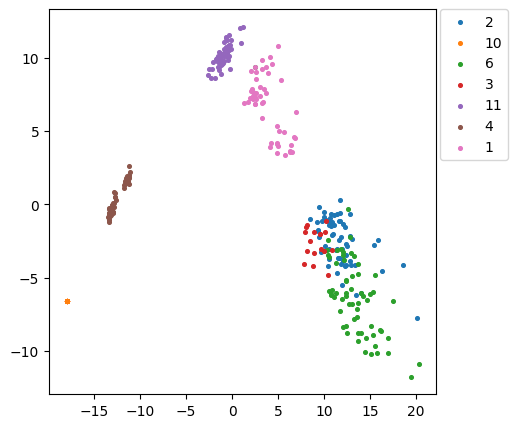

In [16]:
import matplotlib.cm as cm
plt.figure(figsize=(5, 5))
for i, (pid, embedding) in enumerate(embedding_dict.items()):
    # if i not in range(15, 20):
    #     continue
    plt.scatter(
        embedding[:, 0], embedding[:, 1], s=7, label=pid
    )
    # for j in range(len(embedding)):
    #     if embedding[j, n_components] in start_frame_nums[::batch_num - 1]:
    #         plt.text(embedding[j, 0], embedding[j, 1], int(embedding[j, 2]))

# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(pids)
# plt.xlim((-10, 30))
# plt.ylim((-20, 20))
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()

In [17]:
features_aligned_all = feature_aligned.reshape(-1, 256 * output_size**2)
um = umap.UMAP(n_neighbors=3, n_components=n_components, random_state=64)
um.fit(features_aligned_all)
# pca = PCA(n_components=2)
# pca.fit(features_aligned_all)

embedding_dict = {}
tail_idx = 0
for pid_batch, start_frame_num in zip(pids_all_batch, start_frame_nums):
    data_num = len(pid_batch)
    # pca = PCA(n_components=2)
    # pca.fit(feature_aligned[tail_idx: tail_idx + data_num].reshape(-1, 256 * 2 * 2))
    for i, pid in enumerate(pid_batch):
        features = feature_aligned[i + tail_idx]
        embedding = um.transform(features.reshape(-1, 256 * output_size**2))
        # embedding = pca.transform(features.reshape(-1, 256 * output_size**2))

        if pid not in embedding_dict:
            embedding_dict[pid] = np.empty((0, n_components + 1))
        embedding = np.append(embedding, start_frame_num)
        embedding_dict[pid] = np.append(embedding_dict[pid], [embedding], axis=0)

    tail_idx += data_num

In [18]:
print(start_frame_nums)

[1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423]


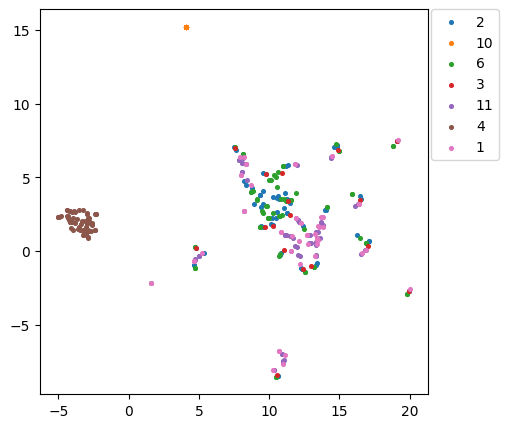

In [19]:
import matplotlib.cm as cm
plt.figure(figsize=(5, 5))
for i, (pid, embedding) in enumerate(embedding_dict.items()):
    # if i not in range(15, 20):
    #     continue
    plt.scatter(
        embedding[:, 0], embedding[:, 1], s=7, label=pid
    )
    # for j in range(len(embedding)):
    #     if embedding[j, 2] in start_frame_nums[::batch_num - 1]:
    #         plt.text(embedding[j, 0], embedding[j, 1], int(embedding[j, 2]))

# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(pids)
# plt.xlim((-20, 10))
# plt.ylim((-10, 10))
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()